# POL2 Proof of Concept

This notebook is for creating a small dataset consisting of just POL2 guide cells and control cells (no guides), then performing some unsupervised and supervised training of scVI.

## Imports

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
repo_path = '/Users/mincheolkim/Github/'
data_path = '/Users/mincheolkim/Documents/'

In [3]:
import sys
sys.path.append(repo_path + 'scVI')
sys.path.append(repo_path + 'scVI-extensions')

In [4]:
import os

import numpy as np
from sklearn.manifold import TSNE
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter
import pandas as pd
import torch
import imp

from scvi.metrics.clustering import entropy_batch_mixing, get_latent
from scvi.models import VAE, SVAEC, VAEC
from scvi.inference import VariationalInference

/anaconda3/envs/scvi/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
import scvi_extensions.dataset.supervised_data_loader as sdl
import scvi_extensions.dataset.cropseq as cs
import scvi_extensions.inference.supervised_variational_inference as svi
import scvi_extensions.hypothesis_testing.mean as mn

## Create a small metadata file

In [6]:
metadata_filename = data_path + 'nsnp20.raw.sng.km_vb1.norm.meta.txt'
abridged_metadata_filename = data_path + 'batf_nc_metadata.txt'
metadata = pd.read_csv(metadata_filename, sep='\t')

In [7]:
nc_metadata = metadata.query('guide_cov == "0"').sample(700)
ko_metadata = metadata[metadata.guide_cov.str.contains('BATF')].sample(700)

In [8]:
ko_metadata['guide_cov'] = ko_metadata['guide_cov'].str.slice(0, 4)
nc_metadata['guide_cov'] = 'NO_GUIDE'

In [9]:
abridged_metadata = pd.concat([ko_metadata, nc_metadata])
abridged_metadata.to_csv(abridged_metadata_filename, sep='\t')

## Create a dataset

In [10]:
h5_filename = '/Users/mincheolkim/Documents/raw_gene_bc_matrices_h5.h5'

In [11]:
imp.reload(cs)
# Load the dataset
gene_dataset = cs.CropseqDataset(
    filename=h5_filename,
    metadata_filename=abridged_metadata_filename,
    new_n_genes=1000,
    use_donors=True,
    use_labels=True,
    save_path='')

Preprocessing CROP-seq dataset
Number of cells kept after filtering with metadata: 1400
Number of cells kept after removing all zero cells: 1400
Finished preprocessing CROP-seq dataset
Downsampling from 32738 to 1000 genes


## Useful functions

In [12]:
def plot_pair_densities(vae, inference, n_points=1000, sigma=1.5):
    latent, batch_indices, labels = get_latent(vae, inference.data_loaders['sequential'])
    latent, idx_t_sne = inference.apply_t_sne(latent, n_points)
    batch_indices = batch_indices[idx_t_sne].ravel()
    labels = labels[idx_t_sne].ravel()
    
    plt.figure(figsize=(10, 20))
    for label, guide in enumerate(inference.gene_dataset.guide_lookup):
        guide_latent = latent[labels == label, :]
        guide_heatmap, guide_xedges, guide_yedges = np.histogram2d(guide_latent[:, 0], guide_latent[:, 1], bins=30)
        guide_heatmap = gaussian_filter(guide_heatmap, sigma=sigma)
        plt.subplot(1, len(inference.gene_dataset.guide_lookup)+1, label+1)
        plt.imshow(guide_heatmap.T, extent=None, origin='lower', cmap=matplotlib.cm.jet, aspect=1)
        plt.title(guide)
    plt.show()

## Unsupervised Model

### Training

In [13]:
n_epochs=200
lr=1e-4
use_batches=True
use_cuda=False

In [116]:
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches * use_batches)
infer = VariationalInference(
    vae, 
    gene_dataset, 
    train_size=0.9, 
    use_cuda=use_cuda,
    verbose=False,
    frequency=1)
infer.train(n_epochs=n_epochs, lr=lr)

training: 100%|██████████| 200/200 [03:05<00:00,  1.08it/s]


Text(0.5,0,'iter')

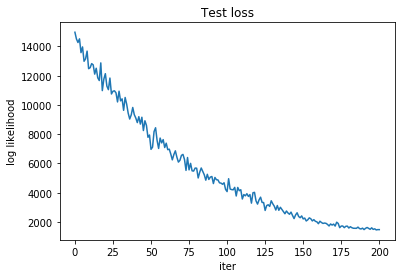

In [117]:
plt.plot(infer.history['ll_test'])
plt.title('Test loss')
plt.ylabel('log likelihood')
plt.xlabel('iter')

### t-SNE

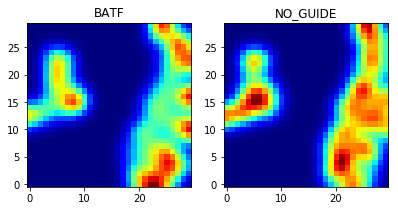

In [118]:
plot_pair_densities(vae, infer)

## Supervised Model

### Supervised training

In [14]:
vaec = VAEC(gene_dataset.nb_genes, n_labels=gene_dataset.n_labels, n_batch=gene_dataset.n_batches * use_batches)
supervised_infer = svi.SupervisedVariationalInference(
    vaec, 
    gene_dataset, 
    train_size=0.9, 
    use_cuda=use_cuda,
    verbose=False,
    frequency=1)
supervised_infer.train(n_epochs=n_epochs, lr=lr)

training: 100%|██████████| 200/200 [03:43<00:00,  1.12s/it]


Text(0.5,0,'iter')

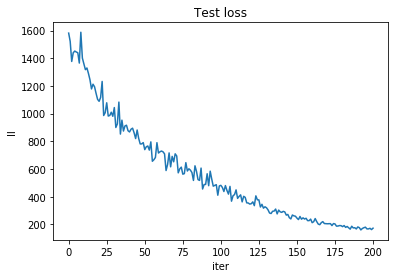

In [15]:
plt.plot(supervised_infer.history['ll_test'])
plt.title('Test loss')
plt.ylabel('ll')
plt.xlabel('iter')

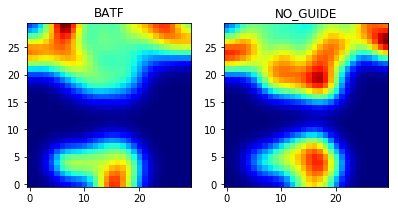

In [17]:
plot_pair_densities(vaec, supervised_infer, n_points=5000, sigma=2)